In [18]:
import sys, os
from pathlib import Path

# find repo root (parent of "experiments") and add to sys.path
repo_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path(os.getcwd()).parents[0]
sys.path.insert(0, str(repo_root))

from eap_fit_hh.inference import EKFTrainer
from eap_fit_hh.utils import compute_comp_xyz, distance, plot_cond_params, compute_eap, build_axial_matrix, build_eap_M, get_surface_areas

In [19]:
import jaxley as jx
from jaxley.channels import HH
import networkx as nx
from jaxley.io.graph import swc_to_graph, make_jaxley_compatible, from_graph, to_graph
import matplotlib as mpl
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random
import tensorflow_probability.substrates.jax as tfp
tf = tfp.tf2jax
tfd = tfp.distributions

In [20]:
ncomps_per_branch = 10
nbranches = 1
n_nodes = 2*nbranches
ncomps = nbranches * ncomps_per_branch
comp = jx.Compartment()
cell = jx.Branch(comp, ncomp=ncomps_per_branch)

cell.insert(HH())

cell.set("HH_eNa", 53.0)
cell.set("HH_eK", -107.0)
cell.set("HH_eLeak", -88.5188)
cell.set("v", -88.5188)
cell.set("radius",2.)
cell.set("axial_resistivity", 150.)

# different param values for each gp
cell.set("HH_gNa",  0.12)
cell.set("HH_gK", 0.02)
cell.set("HH_gLeak", 0.0003)
cell.set("length",24.0)

true_cell_positions = compute_comp_xyz(cell)

cell.init_states()

In [21]:
l = 6
x = jnp.array([jnp.arange(jnp.min(true_cell_positions[:,0]), jnp.max(true_cell_positions[:,0])+1, 6.)[0]])
y = jnp.array([0.])
z = jnp.array([5.])
n_points = len(x)
grid = jnp.dstack(jnp.meshgrid(x, y, z)).reshape((n_points, 3))

true_distances = distance(grid, true_cell_positions) # in um
true_distances_CM = true_distances * 10**(-4)

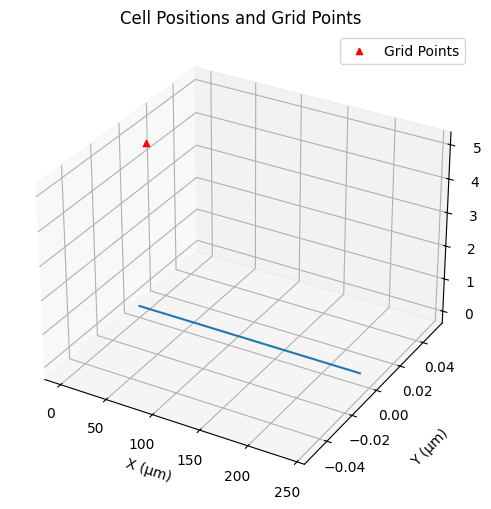

In [22]:
# Create figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot compartments with lines
colors = plt.cm.tab10.colors
cell.vis(ax=ax, color=colors[0])

# Plot grid points
ax.scatter(grid[:, 0], grid[:, 1], grid[:, 2], c='r', marker='^', label='Grid Points')

# Labels and legend
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)", labelpad=15)
ax.set_zlabel("Z (μm)")
ax.set_title("Cell Positions and Grid Points")
ax.legend()

In [23]:
dt = 0.025  # ms
t_max = 20.0
times = jnp.arange(0, t_max+2*dt, dt)
n_timesteps = len(times)
current = jx.step_current(i_delay=0.0, i_dur=20., i_amp=1.5, delta_t=dt, t_max=t_max)
cell.comp(0).stimulate(current)

cell.record("v")
cell.record("HH_m")
cell.record("HH_n")
cell.record("HH_h")
cell.record("i_HH")

true_outputs = jx.integrate(cell)

Added 1 external_states. See `.externals` for details.
Added 10 recordings. See `.recordings` for details.
Added 10 recordings. See `.recordings` for details.
Added 10 recordings. See `.recordings` for details.
Added 10 recordings. See `.recordings` for details.
Added 10 recordings. See `.recordings` for details.


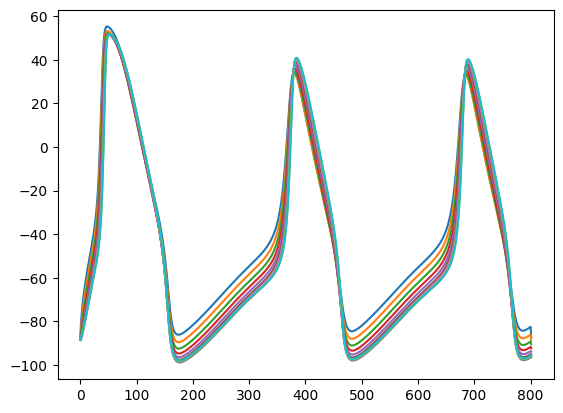

In [24]:
for i in range(ncomps):
    plt.plot(true_outputs[i,:])

In [25]:
A = build_axial_matrix(cell)
padded_current = jnp.concatenate([jnp.array([0.]),current])
M = build_eap_M(A, true_distances_CM, 300)
v = true_outputs[:ncomps]
extr_voltage = compute_eap(v, M, padded_current, 0, true_distances_CM, 300)
emissions_EAP = extr_voltage  + tfd.Normal(0,0.001).sample((n_points, n_timesteps), seed=random.PRNGKey(1))

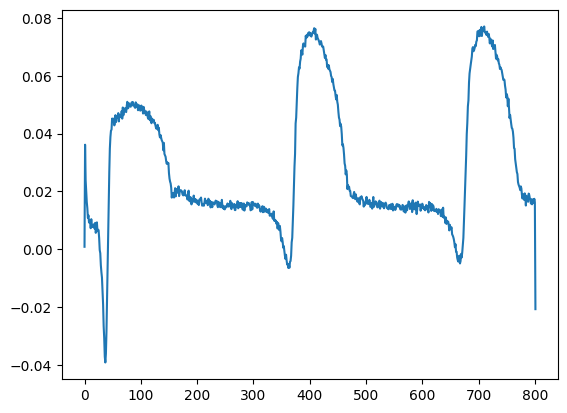

In [26]:
for i in range(len(emissions_EAP)):
    plt.plot(emissions_EAP[i])

In [27]:
HH_params = ['HH_gNa', 'HH_gK', 'HH_gLeak']

In [28]:
dynamics_std = {'v': 0.0001, 'HH_n': 0.00001, 'HH_m': 0.00001, 'HH_h': 0.00001, 'i_HH': 0.01}

In [29]:
Trainer = EKFTrainer(cell = cell,
                     trainable_params = HH_params,
                     dynamics_std = dynamics_std,
                     dt = dt,
                     grid = grid,
                     extracellular_resistivity = 300)

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
['HH_gNa', 'HH_gK', 'HH_gLeak']
['HH_gNa', 'HH_gK', 'HH_gLeak']


In [30]:
HH_bounds = {"HH_gLeak": (0.00005, 0.0005),
          "HH_gNa": (0.05, 0.12),
          "HH_gK": (0.005, 0.05)}

init_cond_params = Trainer.sample_cond_params(bounds = HH_bounds, key = 3)

In [32]:
out = Trainer.train(data = (emissions_EAP.T, current),
            init_cond_params = init_cond_params,
            obs_std = 0.001,
            lr = 0.1,
            num_epochs = 200,
            output = ['cond_params'],
            diagonal = "bloc-diagonal")

EKF train: 100%|██████████████████████████████| 200/200 [02:19<00:00,  1.43it/s]


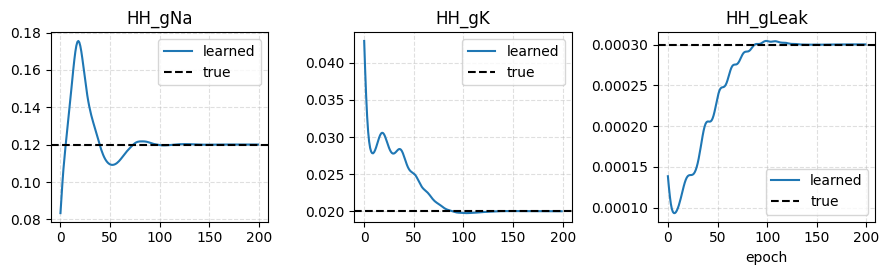

In [33]:
inferred_params, true_params = out["cond_params"], Trainer.ref_cond_params
plot_cond_params(params = inferred_params, true_params = true_params)